In [3]:
import sys
sys.path.append('src')
from src.trainer import EuroSATTrainer
from src.load_data import get_eurosat_dataloaders
from src.load_data import download_eurosat_data
import geopandas as gpd # for reading shapefiles
import folium  # library to create interactive maps
from shapely.geometry import MultiPolygon, Polygon
import os 
import rasterio as rio
from rasterio.mask import mask
import zipfile
import rasterio
import json
import shutil
import cv2
import numpy as np
from tqdm import tqdm
import torch
from collections import Counter

# read credentials.json
with open('credentials.json') as f:
    credentials = json.load(f)

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# load model which standardizes input impages
best_model_path = 'bin/epoch=23-step=6767.ckpt'
model = EuroSATTrainer.load_from_checkpoint(best_model_path)

if torch.cuda.is_available():
    model.to('cuda:0');
    print("Model sent to cuda.")



# Comparision between 3 Rasters

The below code is for a spot-check esque analysis of 3 images from the same time,

In [ ]:
# load rasters (downloaded through Sentinel Data Download Walkthrough.ipynb)
earliest_raster = rio.open('data/S2A_MSIL2A_20220226T154221_N0400_R011_T18TWL_20220226T204651.tiff').read()
middle_raster = rio.open('data/S2A_MSIL2A_20220510T154821_N0400_R054_T18TWL_20220510T230512.tiff').read()
latest_raster = rio.open('data/S2A_MSIL2A_20220825T155151_N0400_R011_T18TWL_20220825T220800.tiff').read()

In [ ]:
# tiled image setup. Can only feed into model 3x64x64 inputs.
tile = 64
img_height = latest_raster.shape[1]
img_width = latest_raster.shape[2]

num_vertical_tiles = img_height // tile
num_horizontal_tiles = img_width // tile

cropped_latest_img = latest_raster[:,:tile*num_vertical_tiles, :tile*num_horizontal_tiles]
cropped_middle_img = middle_raster[:,:tile*num_vertical_tiles, :tile*num_horizontal_tiles]
cropped_earliest_img = earliest_raster[:,:tile*num_vertical_tiles, :tile*num_horizontal_tiles]


In [ ]:
# grab label dictionary
_, _, label_dict = get_eurosat_dataloaders(batch_size = 1, limit=1, test_size = .1)

In [ ]:


def get_tiled_predictions(cropped_img):

    tiled_array = np.zeros((cropped_img.shape[1],cropped_img.shape[2]))
    model.eval();
    tile_predictions = []
    tiled_images = []
    with torch.no_grad():
        for i in tqdm(range(0, img_height-tile, tile)):
            for j in range(0, img_width-tile, tile):
                tiled_image = cropped_img[:,i:i+tile,j:j+tile]        
                if tiled_image.std() == 0:
                    tiled_array[i:i+tile,j:j+tile] = -1
                else:
                    x = torch.tensor(tiled_image.astype(np.int16))
                    x = (x - x.min()) / (x.max() - x.min())   
                    y_pred = model.forward(x.unsqueeze(0).cuda())
                    predicted_class = y_pred.argmax().cpu().item()
                    tiled_array[i:i+tile,j:j+tile] = predicted_class
                    tile_predictions.append(predicted_class)
                    tiled_images.append(tiled_image)

    return tile_predictions, tiled_array, tiled_images

In [ ]:
%%time 
# run inference on a sliding window for all tiles of both images.
latest_tile_predictions, latest_tiled_array, latest_tiled_images = get_tiled_predictions(cropped_latest_img)
middle_tile_predictions, middle_tiled_array, middle_tiled_images = get_tiled_predictions(cropped_middle_img)
earliest_tile_predictions, earliest_tiled_array, earliest_tiled_images = get_tiled_predictions(cropped_earliest_img)


In [ ]:
# view distribution of land mass classes for later tile
tile_counter = Counter(latest_tile_predictions)
latest_landmass_counts = {}
for key in tile_counter.keys():
    landmass = label_dict[key].replace('/','')
    latest_landmass_counts[landmass] = tile_counter[key]
    
plt.figure(figsize=(10,4))    

names = list(latest_landmass_counts.keys())
values = list(latest_landmass_counts.values())
plt.subplot(122)
plt.bar(range(len(latest_landmass_counts)), values, tick_label=names)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.subplot(121)
plt.imshow(cropped_latest_img.mean(axis=0),cmap='gray')
plt.imshow(latest_tiled_array,alpha=.25,cmap='plasma')
plt.axis('off')
plt.suptitle("2022-08-25",fontsize=20)



In [ ]:
# view distribution of landmass types for earlier tile
tile_counter = Counter(middle_tile_predictions)
middle_landmass_counts = {}
for key in tile_counter.keys():
    landmass = label_dict[key].replace('/','')
    middle_landmass_counts[landmass] = tile_counter[key]

plt.figure(figsize=(10,4))    
names = list(middle_landmass_counts.keys())
values = list(middle_landmass_counts.values())
plt.subplot(122)
plt.bar(range(len(middle_landmass_counts)), values, tick_label=names)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.subplot(121)
plt.imshow(cropped_middle_img.mean(axis=0),cmap='gray')
plt.imshow(middle_tiled_array,alpha=.25,cmap='plasma')
plt.axis('off')
plt.suptitle("2022-05-10",fontsize=20)



In [ ]:
# view distribution of landmass types for earlier tile
tile_counter = Counter(earliest_tile_predictions)
earliest_landmass_counts = {}
for key in tile_counter.keys():
    landmass = label_dict[key].replace('/','')
    earliest_landmass_counts[landmass] = tile_counter[key]

plt.figure(figsize=(10,4))    
names = list(earliest_landmass_counts.keys())
values = list(earliest_landmass_counts.values())
plt.subplot(122)
plt.bar(range(len(earliest_landmass_counts)), values, tick_label=names)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.subplot(121)
plt.imshow(cropped_earliest_img.mean(axis=0),cmap='gray')
plt.imshow(earliest_tiled_array,alpha=.25,cmap='plasma')
plt.axis('off')
plt.suptitle("2022-02-26",fontsize=20)



# get percent change of each

In [ ]:
pct_change_landmass = {}
for key in middle_landmass_counts:
    if key not in latest_landmass_counts:
        pct_change_landmass[key] = 0
    else:
        pct_change_landmass[key] = (latest_landmass_counts[key] - middle_landmass_counts[key]) / middle_landmass_counts[key]
        
pct_change_landmass = dict(sorted(pct_change_landmass.items(), key=lambda item: item[1]))

names = list(pct_change_landmass.keys())
values = list(pct_change_landmass.values())

plt.bar(range(len(pct_change_landmass)), values, tick_label=names)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel("% Change",fontsize=15)        

In [ ]:
earliest_landmass_counts, middle_landmass_counts,latest_landmass_counts

In [ ]:
manmade_features = ['Industrial','Highway','Residential']
natural_features = ['AnnualCrop','PermanentCrop','HerbaceousVegetation','Forest','Pasture']
water_features = ['SeaLake','River']


In [ ]:
# view plots of all changed landmass predictions
for i, (earliest_pred, latest_pred) in enumerate(zip(earliest_tile_predictions,latest_tile_predictions)):
    if earliest_pred != latest_pred:
        plt.figure(figsize = (6,3))
        plt.subplot(121)
        plt.imshow(earliest_tiled_images[i].mean(axis=0),cmap='gray')
        plt.title(label_dict[earliest_pred].replace('/',''))
        plt.subplot(122)
        plt.imshow(latest_tiled_images[i].mean(axis=0),cmap='gray')
        plt.title(label_dict[latest_pred].replace('/',''))


In [ ]:
tile_prediction_pairs = []
for i, (earliest_pred, latest_pred) in enumerate(zip(earliest_tile_predictions,latest_tile_predictions)):
    tile_prediction_pairs.append((earliest_pred,latest_pred))

In [ ]:
label_dict

In [ ]:
# view what the most common tile prediction changes were.
Counter(tile_prediction_pairs).most_common()

In [ ]:

for i in tqdm(range(len(tile_prediction_pairs))):
    if tile_prediction_pairs[i] == (2,3):

        
        earliest_pred = earliest_tile_predictions[i]
        middle_pred = middle_tile_predictions[i]
        latest_pred = latest_tile_predictions[i]
        plt.figure(figsize = (9,3))
        plt.subplot(131)
        plt.imshow(earliest_tiled_images[i].mean(axis=0),cmap='gray')
        plt.title(label_dict[earliest_pred].replace('/',''))
        plt.subplot(132)
        plt.imshow(middle_tiled_images[i].mean(axis=0),cmap='gray')
        plt.title(label_dict[middle_pred].replace('/',''))
        
        plt.subplot(133)
        plt.imshow(latest_tiled_images[i].mean(axis=0),cmap='gray')
        plt.title(label_dict[latest_pred].replace('/',''))


In [ ]:
i = tile_prediction_pairs.index((6,3))

earliest_pred = earliest_tile_predictions[i]
latest_pred = latest_tile_predictions[i]
plt.figure(figsize = (6,3))
plt.subplot(121)
plt.imshow(earliest_tiled_images[i].mean(axis=0),cmap='gray')
plt.title(label_dict[earliest_pred].replace('/',''))
plt.subplot(122)
plt.imshow(latest_tiled_images[i].mean(axis=0),cmap='gray')
plt.title(label_dict[latest_pred].replace('/',''))


In [4]:
rasters = [f for f in os.listdir('data/') if f.endswith('.tiff')]

In [26]:
from datetime import datetime


In [27]:
dates = []
for img in rasters:
    # open image
    date = img.split('_')[2].split('T')[0]
    year = date[:4]
    month = date[4:6]
    day = date[6:]
    date_str = f"{year}-{month}-{day}"
    date = datetime.strptime(date_str, '%Y-%m-%d')
    dates.append(date)

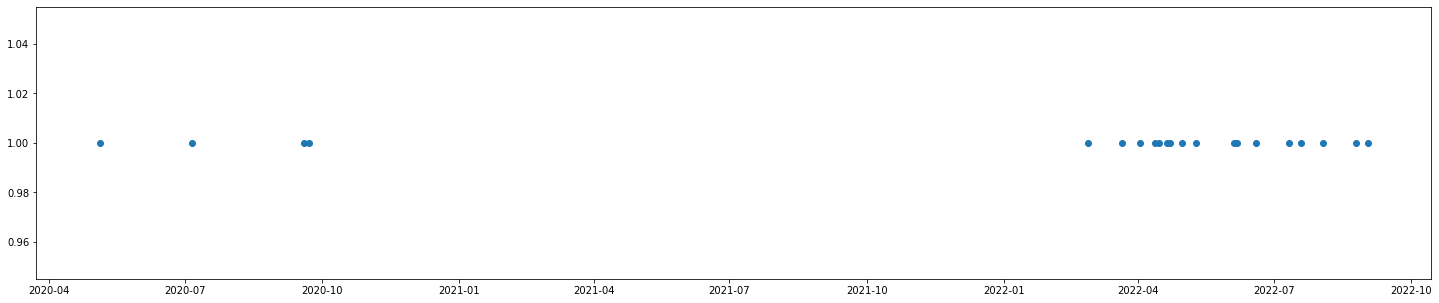

In [28]:
plt.figure(figsize=(25,5))
plt.plot(dates,[1 for x in dates],'o')

And from here can plot pct of a given crop type, and so on. 